In [10]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import precision_recall_curve, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb
df = pd.read_csv('creditcard.csv')
df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Explore and Preprocess the Data

#Check for Missing Values


In [2]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [3]:
df.dropna(inplace=True)

Check the Class Distribution Imbalanced Classes

In [4]:
df['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

#Data Preprocessing

Feature Scaling

In [5]:
from sklearn.preprocessing import StandardScaler

X = df.drop(columns=['Class'])
y = df['Class']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Handle Class Imbalance Using SMOTE

In [6]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)
np.bincount(y_resampled)


array([284315, 284315], dtype=int64)

#Split the Data for Training and Testing

In [7]:
df['Time'] = pd.to_datetime(df['Time'], unit='s')
df.sort_values(by='Time', inplace=True)
split_time = df['Time'].quantile(0.8)
train_data = df[df['Time'] < split_time]
test_data = df[df['Time'] >= split_time]
X_train = train_data.drop(columns=['Class', 'Time'])
y_train = train_data['Class']
X_test = test_data.drop(columns=['Class', 'Time'])
y_test = test_data['Class']
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Build and Train the Model

In [8]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred = rf.predict(X_test_scaled)

In [11]:
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb.fit(X_train_scaled, y_train)

xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

#Model Evaluation

In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)

y_pred_proba_rf = rf.predict_proba(X_test_scaled)[:, 1]

y_pred_rf = rf.predict(X_test_scaled)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_rf)
f1 = f1_score(y_test, y_pred_rf)
roc_auc = roc_auc_score(y_test, y_pred_proba_rf)

print(f"F1 Score: {f1}")
print(f"ROC AUC: {roc_auc}")

F1 Score: 0.8125
ROC AUC: 0.944422568718102


#Model Explainability

<Figure size 640x480 with 0 Axes>

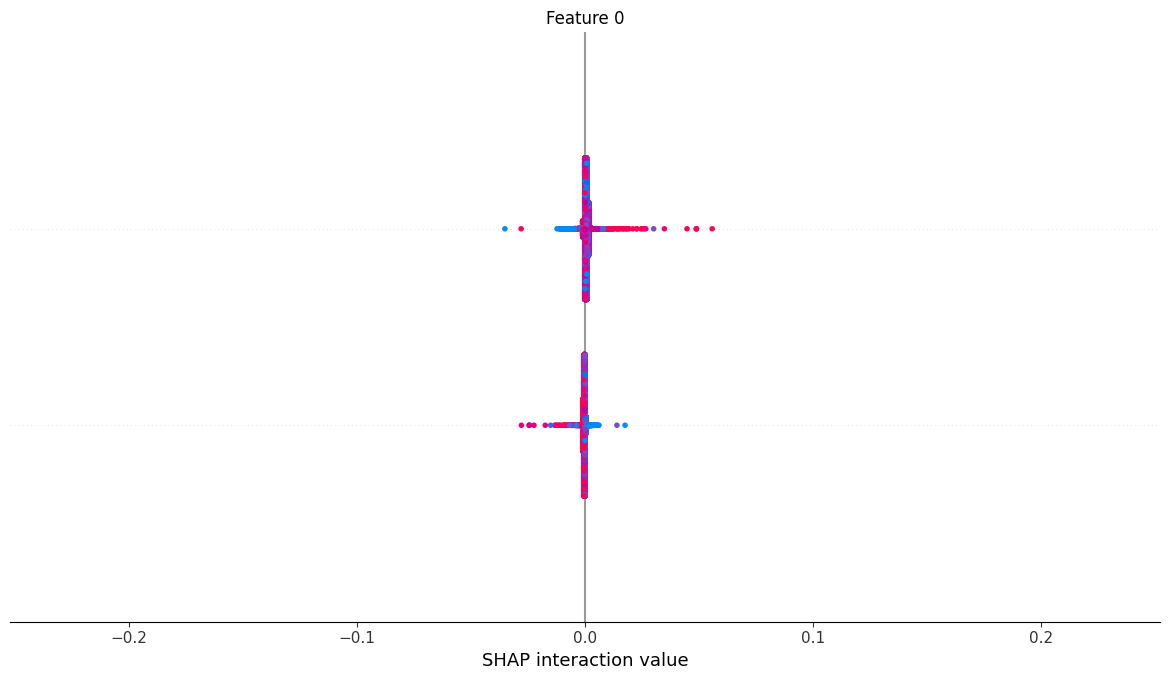

In [13]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test_scaled)
shap.summary_plot(shap_values, X_test_scaled)


F1 Score: 0.8125
ROC AUC: 0.944422568718102


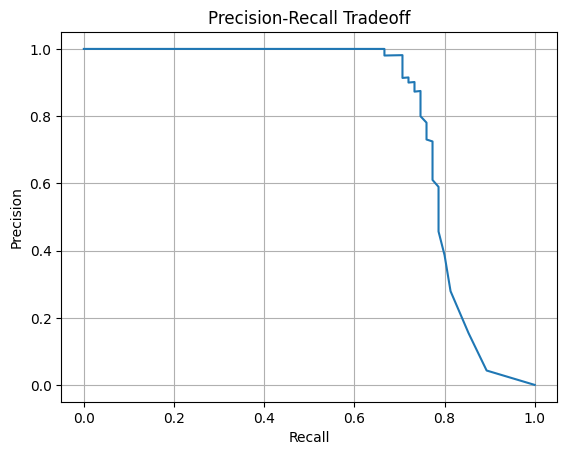

In [14]:
# 3️⃣ Precision-Recall Curve and Tradeoff Plot
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_rf)
f1 = f1_score(y_test, y_pred_rf)
roc_auc = roc_auc_score(y_test, y_pred_proba_rf)

print(f"F1 Score: {f1}")
print(f"ROC AUC: {roc_auc}")

plt.plot(recall, precision)
plt.title("Precision-Recall Tradeoff")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.show()